# Modélisation du taux de chômage

Installation des packages

In [1]:
install.packages("data.table")
remotes::install_github("dbnomics/rdbnomics", build_vignettes = TRUE, force = TRUE)
install.packages("FinTS")
install.packages("forecast")
install.packages("reshape2")
install.packages("lmtest")
install.packages("moments")
install.packages("tseries")
install.packages("Metrics")
install.packages("tsm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




curl (5.0.2 -> 5.1.0) [CRAN]


Installing 1 packages: curl

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpESuZJg/remotes18b778d9a16/dbnomics-rdbnomics-a1db6e5/DESCRIPTION’ ... OK
* preparing ‘rdbnomics’:
* checking DESCRIPTION meta-information ... OK
* installing the package to build vignettes
* creating vignettes ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rdbnomics_0.6.4.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“packag

## Importation de la série du taux de chômage à partir de DB.nomics

On importe les observations trimestrielles du taux de chômage aux Etats-Unis du 1994:T1 au 23:T1 (117 observations) à partir du site [DB.nomics](https://db.nomics.world/BLS ). Les données proviennent du [Bureau of Labor Statistics](https://www.bls.gov/).

In [3]:
library(data.table)
library(rdbnomics)
df<-rdb(ids = "BLS/ln/LNS13327708Q")

Visit <https://db.nomics.world>.



On crée un dataframe contenant uniquement les dates (colonne "period") et la série du taux de chômage (colonne "value").

In [4]:
df_u<-df[,c("period","value")]
colnames(df_u)<-c('date','taux')
head(df_u)
tail(df_u,n=5)

date,taux
<date>,<dbl>
1994-01-01,7.9
1994-04-01,7.4
1994-07-01,7.3
1994-10-01,6.8
1995-01-01,6.6
1995-04-01,6.8


date,taux
<date>,<dbl>
2022-07-01,4.4
2022-10-01,4.4
2023-01-01,4.3
2023-04-01,4.4
2023-07-01,4.5


## Représentation graphique

Le taux de chômage aux Etats-Unis fluctue autour de 6% du début de l'échantillon jusqu'à l'année 2008 à partir de laquelle il augmente très rapidement jusqu'au niveau de 11%, sous l'effet de la crise des subprimes. On observe aussi l'épisode de la crise du Covid avec une hausse instantanée du taux de chômage autour de 14% suivie d'un retour rapide à des niveaux très bas. La période du covid peut avoir un impact sur les résultats des tests statistiques. Au vu du graphique, il est assez difficile de trancher sur la stationnarité du taux de chômage.

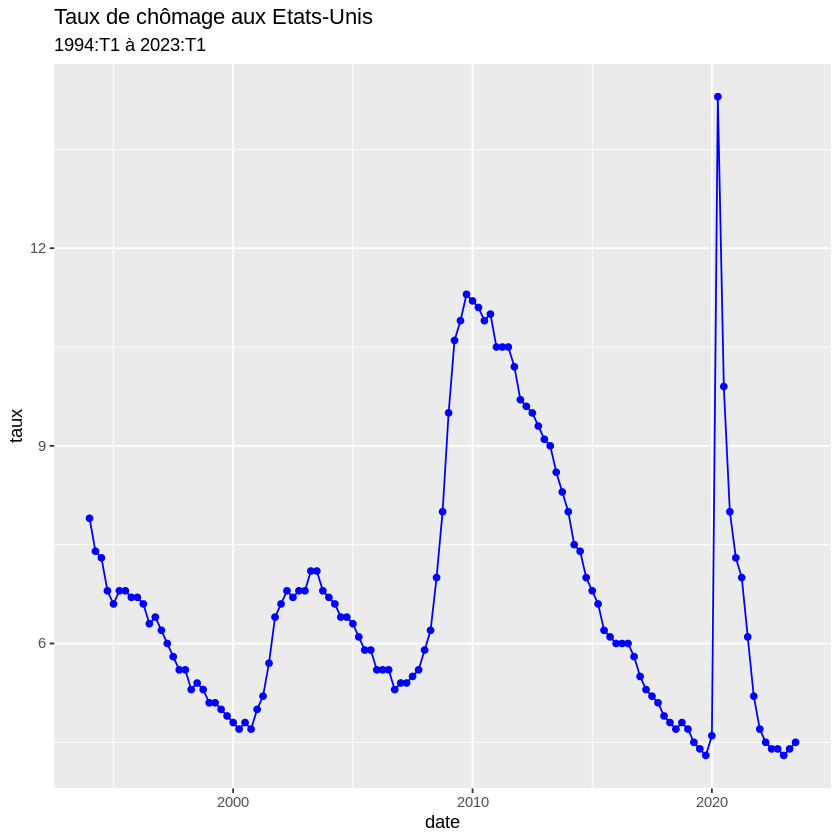

In [5]:
library(ggplot2)
p_us<-ggplot(data=df_u,aes(x=date,y=taux))+geom_point(color='blue')+geom_line(color='blue')
p_us+labs(x="date",y="taux",title = "Taux de chômage aux Etats-Unis",subtitle = "1994:T1 à 2023:T1")

## Estimation sans la période Covid : 1994:T1 à 2019:T4



Dans un premier temps, on exclut les observations à partir du dernier trimestre de l'année 2019.

In [6]:
df_u_19T1=df_u[df_u$date<="2019-10-01",]

### Représentation graphique


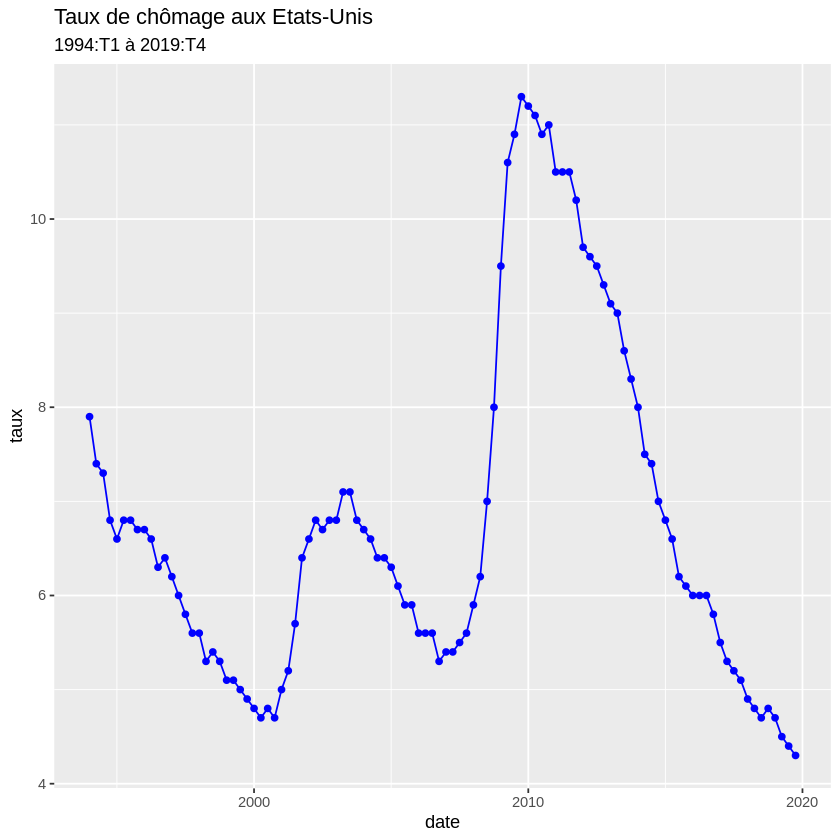

In [7]:
library(ggplot2)
p_us<-ggplot(data=df_u_19T1,aes(x=date,y=taux))+geom_point(color='blue')+geom_line(color='blue')
p_us+labs(x="date",y="taux",title = "Taux de chômage aux Etats-Unis",subtitle = "1994:T1 à 2019:T4")

Le graphique montre que pendant la grande récession de 2008-2009, le taux de chômage a atteint des niveaux nettement plus élevés que depuis le début de l'échantillon.

### Statistiques descriptives et autocorrélogrammes

In [8]:
statdes0<-summary(df_u_19T1$taux)
sprintf("Ecart type %f",sd(df_u_19T1$taux))

[1] "Ecart type 1.848130"


La library FinTS permet aussi de calculer des statistiques descriptives d'une série temporelle.

In [9]:
library(FinTS)
stat_des1<-FinTS.stats(df_u_19T1$taux)
stat_des1

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Warning message in FinTS.stats(df_u_19T1$taux):
“requires(e1071) for skewnessand kurtosis; returning NAs”


Start,Size,Mean,Standard.Deviation,Skewness,Excess.Kurtosis,Minimum,Maximum
<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>
1,104,6.768269,1.84813,NA,NA,4.3,11.3


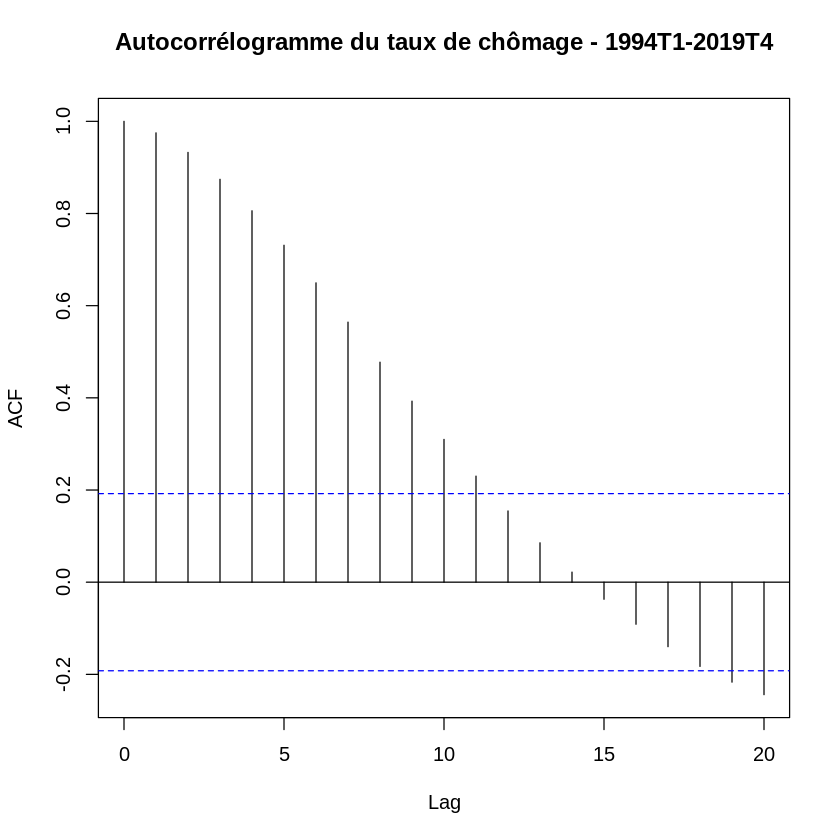

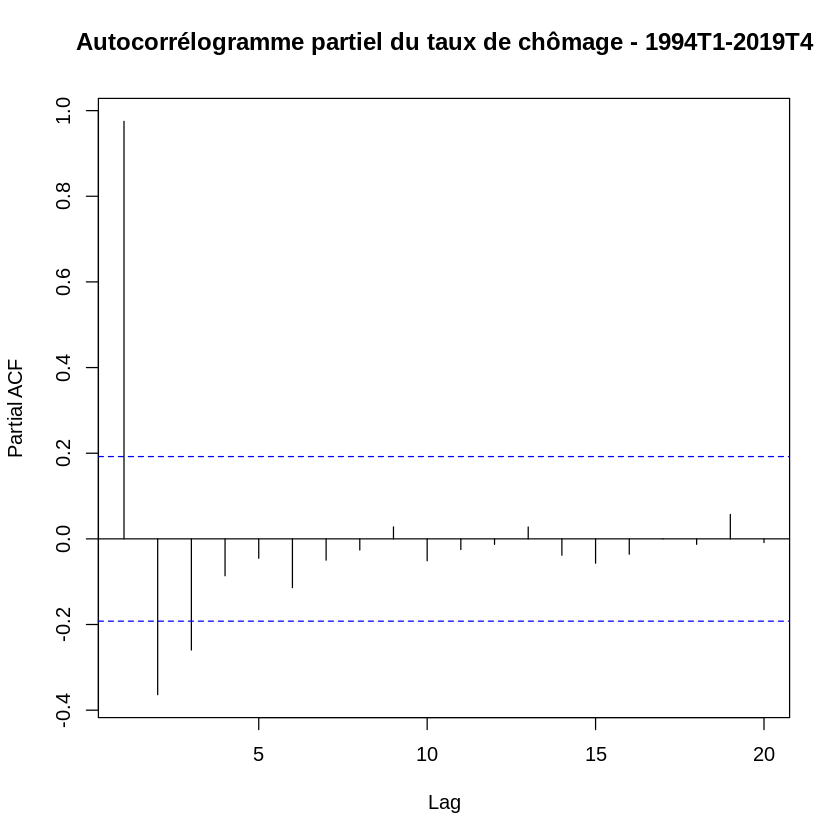

In [10]:
acf_u_19T1<-acf(x=df_u_19T1$taux,main='Autocorrélogramme du taux de chômage - 1994T1-2019T4')
pacf(x=df_u_19T1$taux,main='Autocorrélogramme partiel du taux de chômage - 1994T1-2019T4')

In [11]:
test<-arima.sim(n = 100, list(ma = c(-0.9279, 0.9488)),
          sd = sqrt(1))

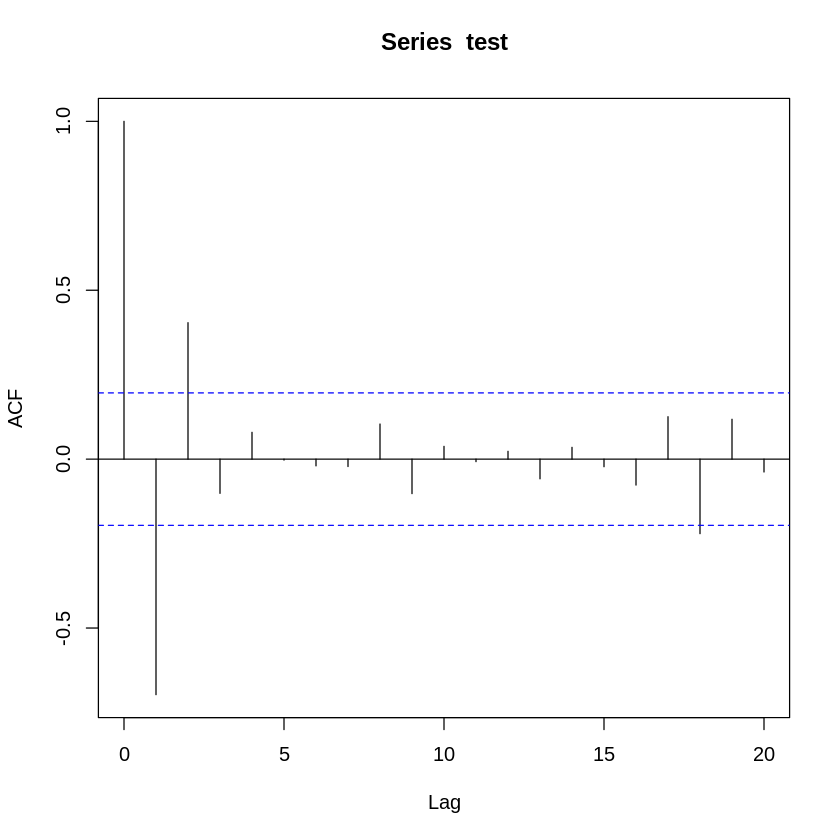

In [12]:
acf(test)

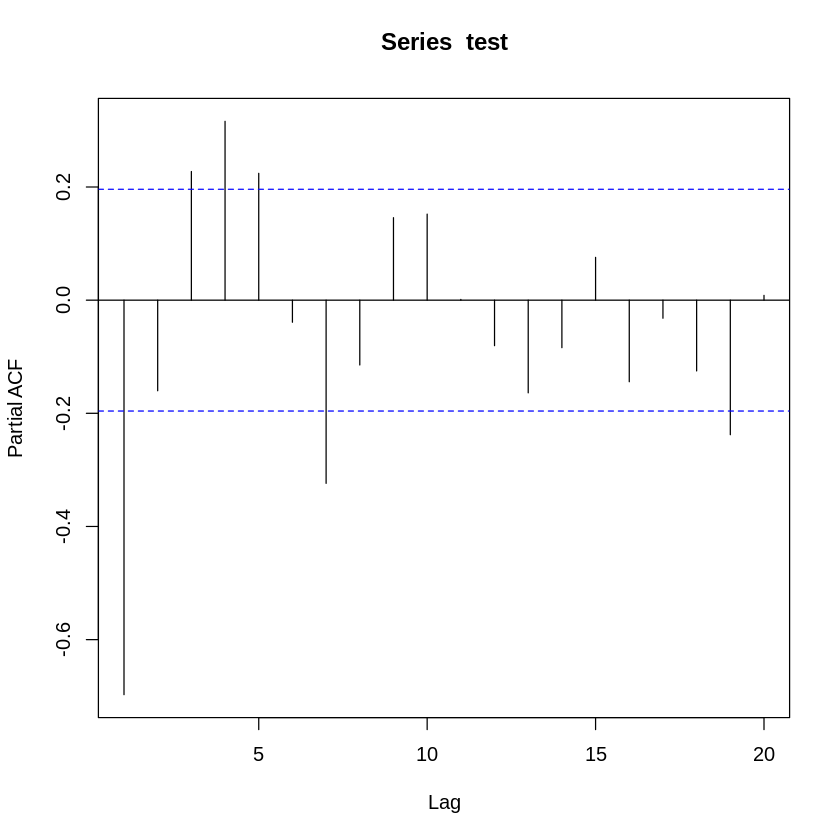

In [13]:
pacf(test)

In [14]:
length(df_u_19T1$taux)

[1] 104

**Commentaires**

* Les autocorrélations sont positives et significativement jusqu'au retard 11.
* Elles sont proches de 1 pour les retards 1, 2, 3, 4 5 puis décroissent vers 0. On en déduit que le taux de chômage est assez autocorrélé. Néanmoins, il est assez difficile de tirer une conclusions sur la stationnarité ou non-stationnarité du taux de chômage. le profil des autocorrélations pourrait correspondre à une série stationnaire.
* Les autocorrélations partielles sont significatives pour les retards 1, 2 et 3.

Le profil des autocorrélations suggère d'esimer un modèle AR(3)

### Estimation et tests de validation d'un modèle ARMA

On va écarter les 4 dernières observations de l'échantillon, c'est-à-dire l'année 2019. Dans notre cas, cela revient à estimer le modèle avec les 100 premières observations. L'objectif est de comparer les valeurs prédites par le modèle final aux valeurs réalisées. Ainsi, on pourra évaluer la qualité des prévisions en-dehors de l'échantillon ("out-of-sample) utilisé pour l'estimer.


On utilise la librairie forecast. En se basant sur l'analyse des autocorrélations, on spécifie un modèle AR(3) :

* order=c(p,d,q) où :

    * p : nombre de retards de la partie AR,
    * d : nombre de différenciations pour obtenir un série stationnaire,
    * q : nombre de retards pour la partie MA
    
* Arima inclut une constante par défaut

In [15]:
library(forecast)
# Estimation d'un  modèle
AR3<-Arima(y = df_u_19T1$taux[1:100],order=c(3,0,0))
# Affichage de l'estimation
summary(AR3)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:FinTS’:

    Acf




Series: df_u_19T1$taux[1:100] 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2      ar3    mean
      1.4712  -0.2221  -0.2827  6.9381
s.e.  0.0966   0.1777   0.0971  0.6218

sigma^2 = 0.05001:  log likelihood = 7.4
AIC=-4.8   AICc=-4.16   BIC=8.22

Training set error measures:
                       ME      RMSE       MAE       MPE     MAPE     MASE
Training set -0.004696549 0.2191125 0.1681198 -0.185275 2.454551 0.774133
                    ACF1
Training set -0.02262365

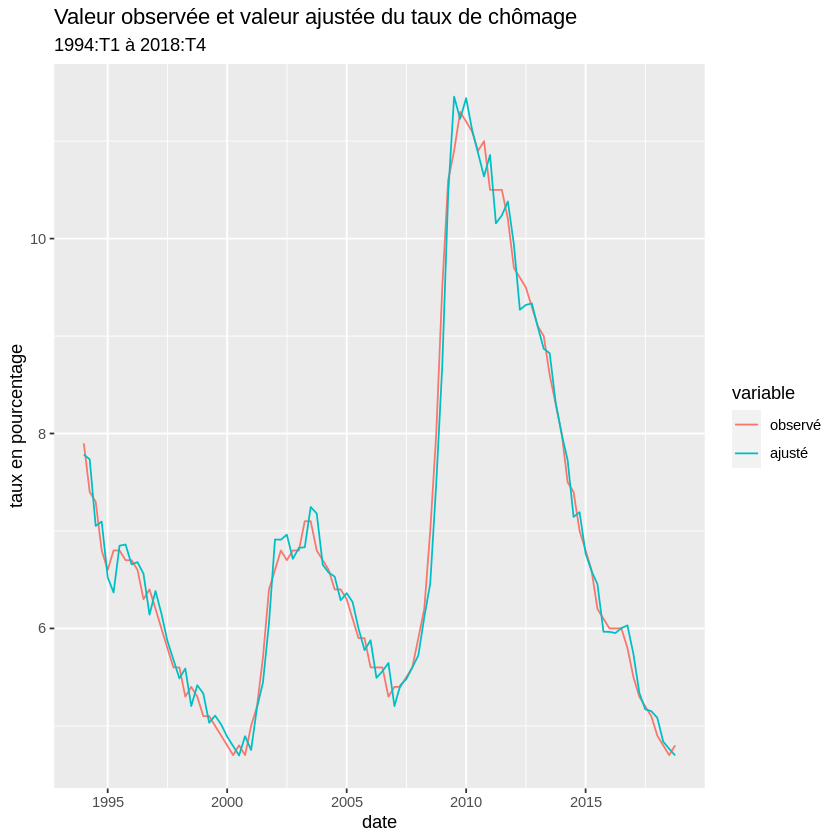

In [ ]:
library(ggplot2)
library(reshape2)

df_plot<-data.frame(df_u_19T1$date[1:100],df_u_19T1$taux[1:100],F=as.matrix(AR3$fitted))
colnames(df_plot)<-c("date","observé","ajusté")

data_melt=melt(as.data.frame(df_plot),id.vars = 1)

p_F_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_F_us+labs(y="taux en pourcentage",title = "Valeur observée et valeur ajustée du taux de chômage",
            subtitle = "1994:T1 à 2018:T4")

#### Test de significativité des coefficients




##### Avec la librairie lmtest

In [ ]:
library(lmtest)
coeftest(AR3)


z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1        1.471196   0.096591 15.2312 < 2.2e-16 ***
ar2       -0.222085   0.177671 -1.2500  0.211308    
ar3       -0.282668   0.097106 -2.9109  0.003604 ** 
intercept  6.938081   0.621805 11.1580 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Commentaires**

1. On vérifie la significativité de la constante :

$$\left\lbrace\begin{array}{l} H_{0}\,:\,c=0\\
H_{a}\,:\,c \neq 0
\end{array} \right.$$

* La statistique de test $t_{\hat{c}} = \frac{\hat{c}}{\hat{\sigma}_{\hat{c}}} \rightarrow N(0,1)$ sous $H_{0}$ car On dispose de 104 observations.
* Les seuils critiques sont :
*       seuil = 2.57 pour un risque de première espèce égal à 1\%
*       seuil = 1.96 pour un risque de première espèce égal à 5\%

* $t_{\hat{c}}=10.107>2.57$ : la constante est significative pour un risque de première espèce de 1 %
* La probabilité critique est inférieure à 1\% pour la constante.

2. On vérifie la significativité celle des coefficients de l'AR(3) :

$$\left\lbrace\begin{array}{l}
H_{0}\,:\,\phi_{i}=0\\
H_{a}\,:\,\phi_{i} \neq 0
\end{array} \right.$$

*    $\vert t_{\hat{\phi}_{1}} \vert > 2.57$ et $\vert t_{\hat{\phi}_{3}}\vert> 2.57$ : les coefficients de retards 1 et 3 de l'AR sont significativement différents de 0 pour un risque de première espèce de 1\%.
*   Les probabilités critiques pour $\hat{\phi}_{1}$ et $\hat{\phi}_{3}$ sont inférieures à 1\% : on rejette l'hypothèse nulle de non-significativité pour un risque de première espèce de 1\%.
*  $\vert t_{\hat{\phi}_{2}} \vert =1.33 < 1.96$ : le coefficient du second retard de l'AR(3) n'est pas significativement différent de 0
*  La probabilité critique de $\hat{\phi}_{2}$ est égale à 18.3 % : ce coefficient n'est pas significatif pour un risque de 5%.
* Le coefficient $\hat{\phi}_{3}$ du dernier retard est significativement différent de 0 : il n'y a pas de retard superflu.


##### Calcul des tstat directement

In [ ]:
AR3$tstat<-AR3$coef/sqrt(diag(AR3$var.coef))# tstat of the ARMA coefficient
AR3$tstat

ar1       ar2       ar3 intercept 
15.231223 -1.249978 -2.910920 11.157962

#### Estimation de spécifications alternatives

On estime un AR(4) pour vérifier s'il n'est pas nécessaire d'ajouter des retards supplémentaires

In [ ]:
AR4<-Arima(y = df_u_19T1$taux[1:100],order=c(3,0,13))
summary(AR4)
coeftest(AR4)
summary(AR3)

Series: df_u_19T1$taux[1:100] 
ARIMA(3,0,13) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ma1     ma2      ma3      ma4      ma5
      1.7464  -0.6013  -0.1556  -0.2881  0.0670  -0.0673  -0.3741  -0.0665
s.e.  0.2308   0.3107   0.0523   0.2103  0.2023   0.2080   0.1104   0.2396
         ma6     ma7      ma8     ma9     ma10     ma11    ma12    ma13    mean
      0.0553  0.0025  -0.3120  0.1530  -0.0437  -0.1275  0.0190  0.0152  6.9885
s.e.  0.1186  0.1486   0.1034  0.2755   0.1092   0.1007  0.1369  0.1200  0.2316

sigma^2 = 0.04712:  log likelihood = 15.98
AIC=4.04   AICc=12.48   BIC=50.93

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.007571251 0.1977669 0.1513472 -0.2130307 2.245441 0.6969009
                    ACF1
Training set -0.02311045


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ar1        1.7464363  0.2307514  7.5685 3.776e-14 ***
ar2       -0.6012613  0.3106642 -1.9354 0.0529405 .  
ar3       -0.1555967  0.0523017 -2.9750 0.0029300 ** 
ma1       -0.2881229  0.2103165 -1.3699 0.1707027    
ma2        0.0669648  0.2022822  0.3310 0.7406096    
ma3       -0.0673450  0.2080058 -0.3238 0.7461158    
ma4       -0.3741059  0.1104069 -3.3884 0.0007029 ***
ma5       -0.0664576  0.2396330 -0.2773 0.7815262    
ma6        0.0553360  0.1185825  0.4666 0.6407535    
ma7        0.0025365  0.1485654  0.0171 0.9863783    
ma8       -0.3120280  0.1033596 -3.0189 0.0025373 ** 
ma9        0.1530093  0.2755208  0.5553 0.5786583    
ma10      -0.0437116  0.1091530 -0.4005 0.6888164    
ma11      -0.1275074  0.1006695 -1.2666 0.2053002    
ma12       0.0190195  0.1369318  0.1389 0.8895309    
ma13       0.0151840  0.1199570  0.1266 0.8992736    
intercept  6.9884576  0.2315996 30.1747 < 2.2e-16 ***
--

Series: df_u_19T1$taux[1:100] 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2      ar3    mean
      1.4712  -0.2221  -0.2827  6.9381
s.e.  0.0966   0.1777   0.0971  0.6218

sigma^2 = 0.05001:  log likelihood = 7.4
AIC=-4.8   AICc=-4.16   BIC=8.22

Training set error measures:
                       ME      RMSE       MAE       MPE     MAPE     MASE
Training set -0.004696549 0.2191125 0.1681198 -0.185275 2.454551 0.774133
                    ACF1
Training set -0.02262365

**Commentaires**

* On voit que le coefficient du quatrième retard ar4 n'est pas significativement différent de 0 $$\vert t_{\hat{\phi}_{4}}\vert=0.693<1.96$$


On estime un ARMA(3,1) pour vérifier s'il n'est pas nécessaire d'ajouter des retards MA supplémentaires

In [ ]:
ARMA31<-Arima(y = df_u_19T1$taux[1:100],order=c(3,0,1))
summary(ARMA31)
coeftest(ARMA31)

Series: df_u_19T1$taux[1:100] 
ARIMA(3,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ar3      ma1    mean
      1.5409  -0.3383  -0.2344  -0.0758  6.9422
s.e.  0.2680   0.4573   0.2022   0.2653  0.6101

sigma^2 = 0.05049:  log likelihood = 7.44
AIC=-2.88   AICc=-1.98   BIC=12.75

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.004633258 0.2190182 0.1675776 -0.1846136 2.447797 0.7716363
                    ACF1
Training set -0.01420855


z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1        1.540930   0.267982  5.7501 8.918e-09 ***
ar2       -0.338255   0.457332 -0.7396    0.4595    
ar3       -0.234379   0.202171 -1.1593    0.2463    
ma1       -0.075757   0.265319 -0.2855    0.7752    
intercept  6.942189   0.610092 11.3789 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Commentaires**

* On voit que le coefficient du premier retard ma1 n'est pas significativement différent de 0 $$\vert t_{\hat{\phi}_{4}}\vert=0.7752<1.96$$ Il n'est pas nécessaire d'ajouter un retard MA.

#### Interprétation des coefficients

Dans la présentation de l'estimation, la constante reportée représente l'espérance de la série. Dans notre exemple les résultats peuvent s'écrire comme :

$$
\left\lbrace
\begin{array}{l}
US\_taux_{t} = 6.7872+\hat{u}_{t}\\
\hat{u}_{t}=1.4712\times \hat{u}_{t-1}-0.2221\times \hat{u}_{t-2}- 0.2827\times \hat{u}_{t-3}+\hat{\epsilon}_{t}
\end{array}
\right.
$$

$6.9381=E(US\_taux_{t})$ et $\hat{u}_{t} = US\_taux_{t}- 6.9381$ est le taux de chômage corrigé de sa moyenne.


#### Analyse des racines




On représente les **inverses** des racines dans le cercle unitaire. La condition de stationnarité impose que ces inverses doivent être de module strictement inférieur à 1, c'est-à-dire dans le cercle unitaire. La condition de stationnarité est donc satisfaite.

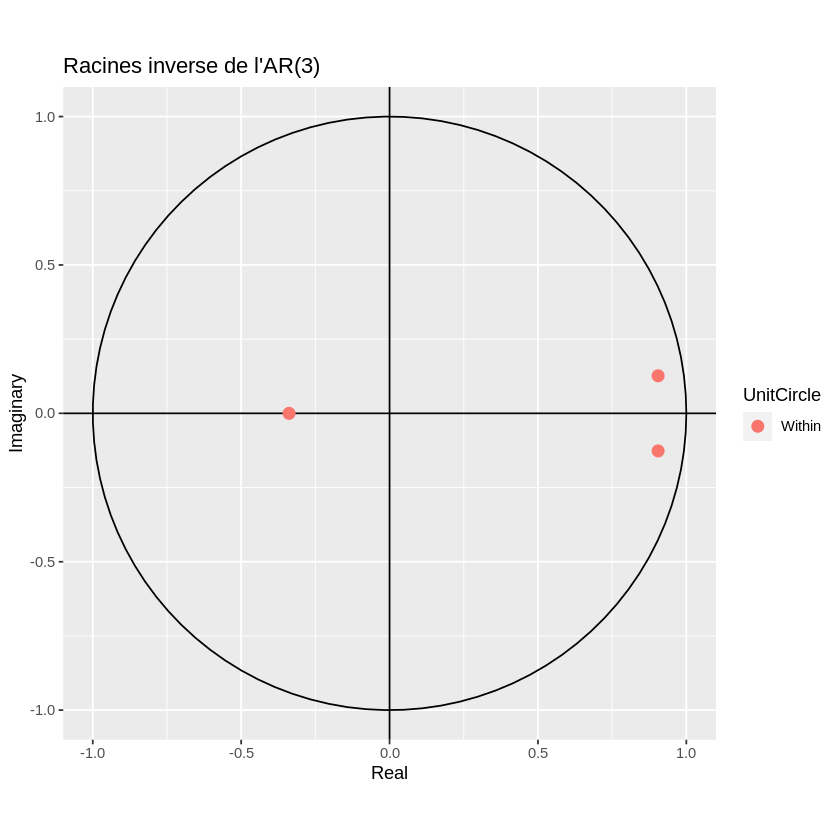

In [ ]:
autoplot(AR3,main="Racines inverse de l\'AR(3)")

#### Tests sur les résidus



Les tests de vérification des résidus sont :

1. Le test d'absence d'autocorrélation de Ljung-Box,
2. Le test de normalité de Jarque et Bera,
3. Le test d'absence d'effet GARCH de Engle et Granger.

##### Tests d'absence d'autocorrélation des résidus

On teste l'absence d'autocorrélation des résidus jusqu'à l'ordre 10. Les hypothèses du test sont :

$$
\left\lbrace
\begin{array}{l}
H_{0}\,:\,\rho(1)=\rho(2)=\ldots=\rho(10)=0\\
H_{a}\,:\,\exists i\in\left\lbrace 1,\cdots,10 \right\rbrace\,\mathrm{tel\,que}\,\rho(i)\neq 0
\end{array}
\right.
$$


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0) with non-zero mean
Q* = 9.1111, df = 7, p-value = 0.2448

Model df: 3.   Total lags used: 10



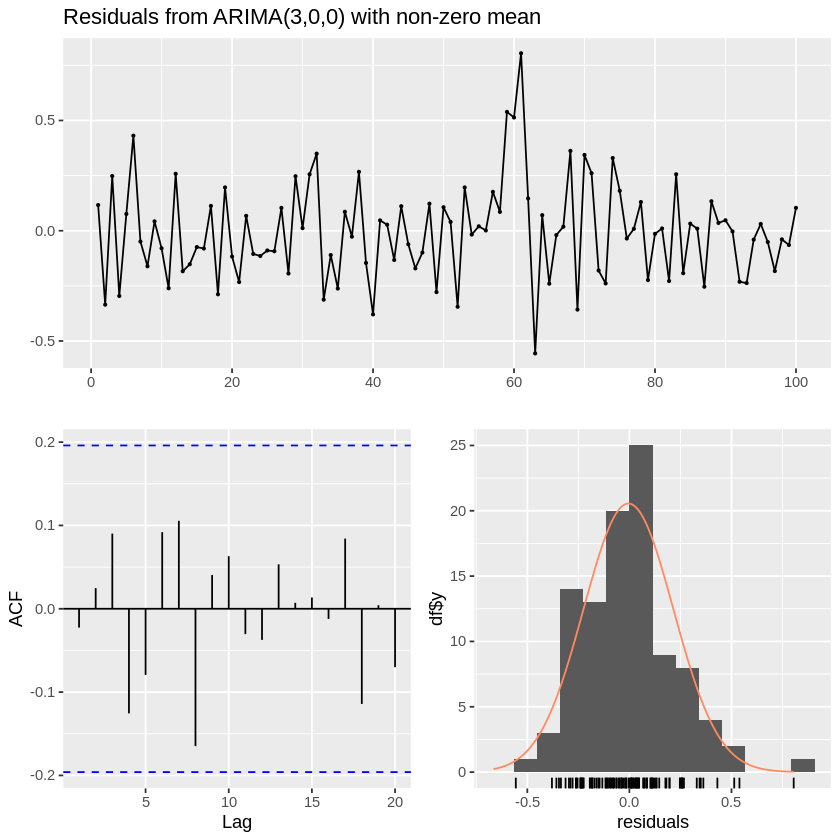

In [16]:
test_resAR3<-checkresiduals(AR3,lag = 10)

**Commentaires**

1. L'autocorrélogramme montre que toutes les autocorrélations sont situées dans les bornes de l'intervalle de confiance à 95\% : aucune des autocorrélations n'est significativement différente de 0.

2. La statistique de test de Ljung-Box est égale à $Q*(10) = 9.1111$.
    + Sous $H_{0}$, $LB\_stat$ suit une loi $\chi^{2}(10-3) = \chi^{2}(7)$.
    + Les seuils critiques sont donc tirés de la loi $\chi^{2}(7)$ :
        + $Q^{*}(10)_{0.90}=12.02$ pour un risque de première espèce de 10%
        + $Q^{*}(10)_{0.95}=14.07$ pour un risque de première espèce de 5%
        + $Q^{*}(10)_{0.99}=18.48$ pour un risque de première espèce de 1%
    + $Q*(10) = 9.1111$  est inférieure à ces seuils critiques. On ne rejette pas l'hypothèse nulle d'absence d'autocorrélation des résidus pour un risque de première espèce de 1%.
    + La probabilité critique est égale à $0.2665$. Elle est supérieure aux risques de première espèce habituel (1%, 5% et 10%). On ne rejette pas l'hypothèse nulle d'absence d'autocorrélation des résidus.


##### Test de l'hypothèse de normalité des résidus

On représente :

1. l'histogramme des résidus (rectangles gris )
2. l'histogramme d'une loi normale avec la même moyenne et le même écart type que celui des résidu (trait rouge)



In [29]:
which(AR3$residuals==max(AR3$residuals))
#which(AR3$residuals==min(AR3$residuals))
#df_u_19T1[c(57,58,59,60),]

[1] 61

[1] "Skewness des residus : 0.245562"

[1] "kurtosis des residus : 3.034881"

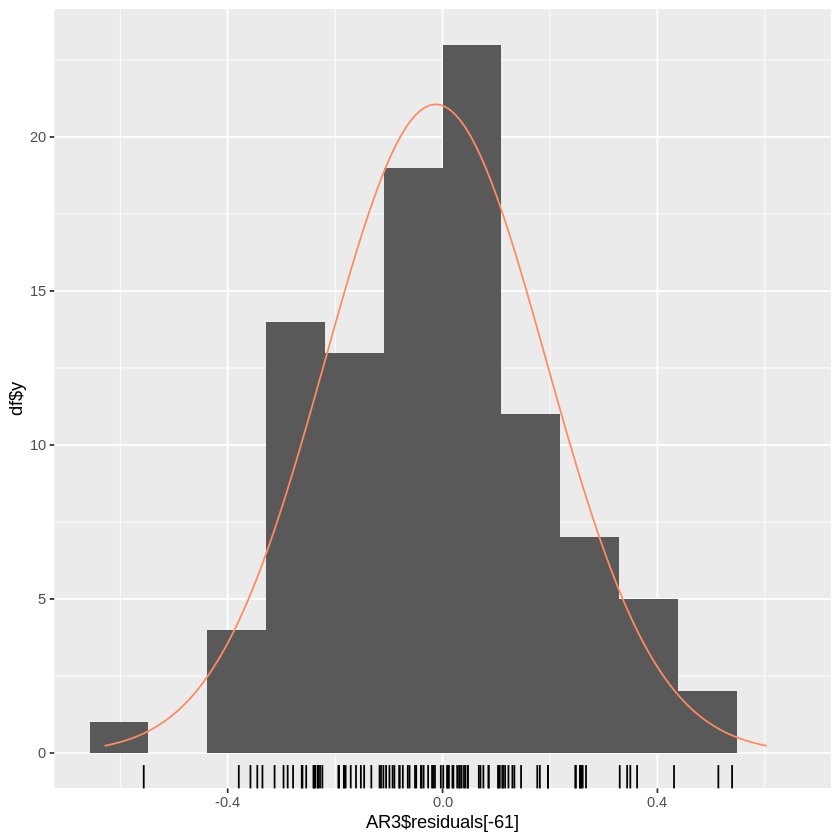

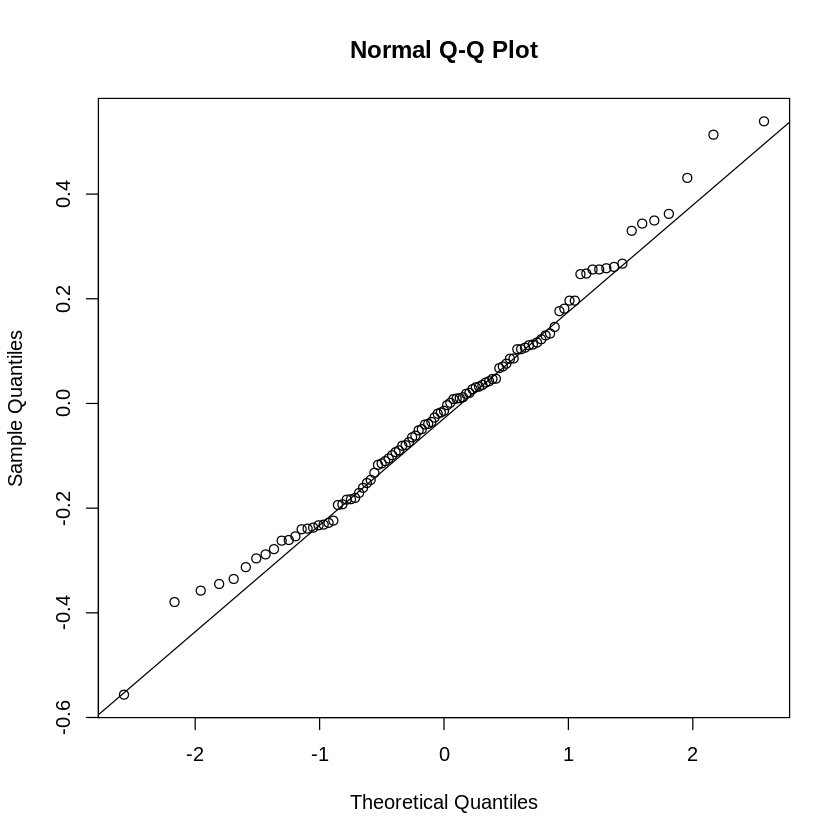

In [31]:
gghistogram(AR3$residuals[-61], add.normal = TRUE)
library(moments)
sprintf("Skewness des residus : %f",skewness(AR3$residuals[-61]))
sprintf("kurtosis des residus : %f",kurtosis(AR3$residuals[-61]))
qqnorm(AR3$residuals[-61])
qqline(AR3$residuals[-61])

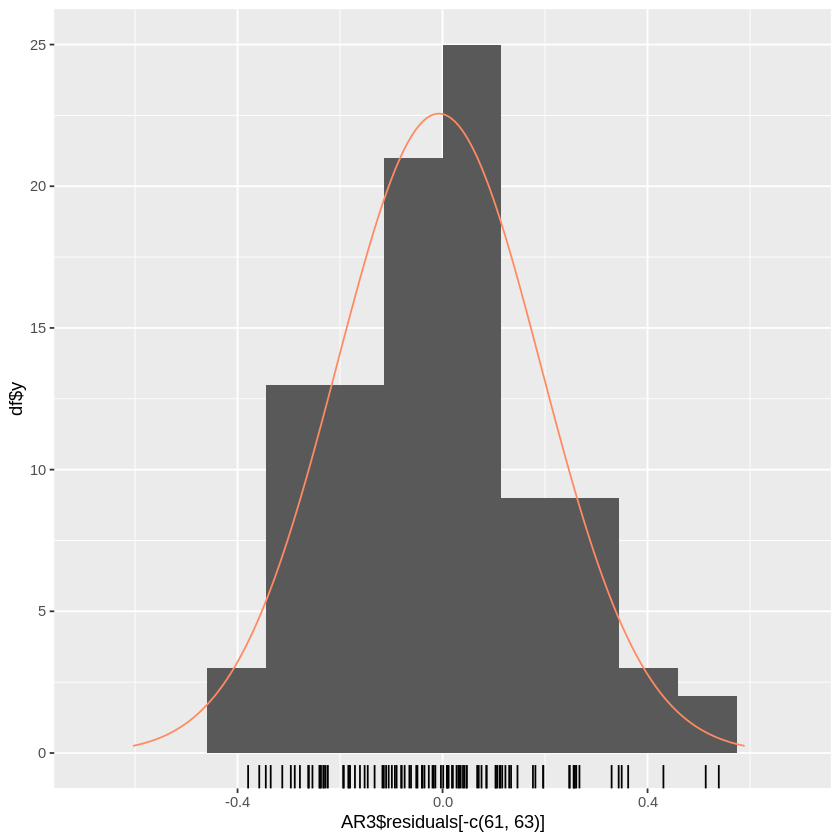

In [ ]:
gghistogram(AR3$residuals[-c(61,63)], add.normal = TRUE)

On peut voir qu'il existe des différences entre les deux histogrammes ce qui permet de supposer que les résidus ne suivent pas une loi normale.

##### Test de l'hypothèse en normalité de Jarque and Bera

In [18]:
library(moments)
sprintf("Skewness des residus : %f",skewness(AR3$residuals[-c(61,63)]))
sprintf("kurtosis des residus : %f",kurtosis(AR3$residuals[-c(61,63)]))

[1] "Skewness des residus : 0.400561"

[1] "kurtosis des residus : 2.859594"

* Le skewness estimé est positif : on a une asymétrie du côté des valeurs positives
* Le kurtosis estimé est supérieur à 3 : c'est l'indice d'une loi non gaussienne

In [35]:
library(tseries)
jarque.bera.test(AR3$residuals)
jarque.bera.test(AR3$residuals[-c(61)])


	Jarque Bera Test

data:  AR3$residuals
X-squared = 11.338, df = 2, p-value = 0.003452



	Jarque Bera Test

data:  AR3$residuals[-c(61)]
X-squared = 0.99998, df = 2, p-value = 0.6065


Les hypothèses du test sont :

$$
\left\lbrace
\begin{array}{l}
H_ {0}:\,S(X)=0\;et\;K(X)=3\\
H_ {1}:\,S(X)\neq 0\; ou\;K(X)\neq 3
\end{array}
\right.
$$

* La statistique du test de Jarque et Bera est égale à  est JB\_stat = 11.338.
* Sous $H_{0}$, LB\_stat suit une loi $\chi^{2}(2)$.
* Les seuils critiques sont :
    + $\chi^{2}_{0.90}(2)=4.61$ pour un risque de première espèce de 10%
    + $\chi^{2}_{0.95}(2)=5.99$ pour un risque de première espèce de 5%
    + $\chi^{2}_{0.99}(2)=9.21$ pour un risque de première espèce de 1%
    
* JB\_stat = 11.338 est supérieure aux seuils critiques pour des risques de première espèce de 1%, 5% et 10\% : on rejette l'hypothèse d'une loi normale pour les résidus.
* La probabilité critique est égale à $0.001$ : on rejette l'hypothèse nulle de loi normale à 10%, 5\% et 1%.
* Le rejet de l'hypothèse de normalité peut s'expliquer par les pics du taux de chômage observés en 2010(grande récession). Le valeur du taux de chômage est alors beaucoup plus élevée que lors de période précédente. Ceci peut expliquer le kurtosis supérieur à 3

##### Test de Engle Granger d'absence d'effet ARCH



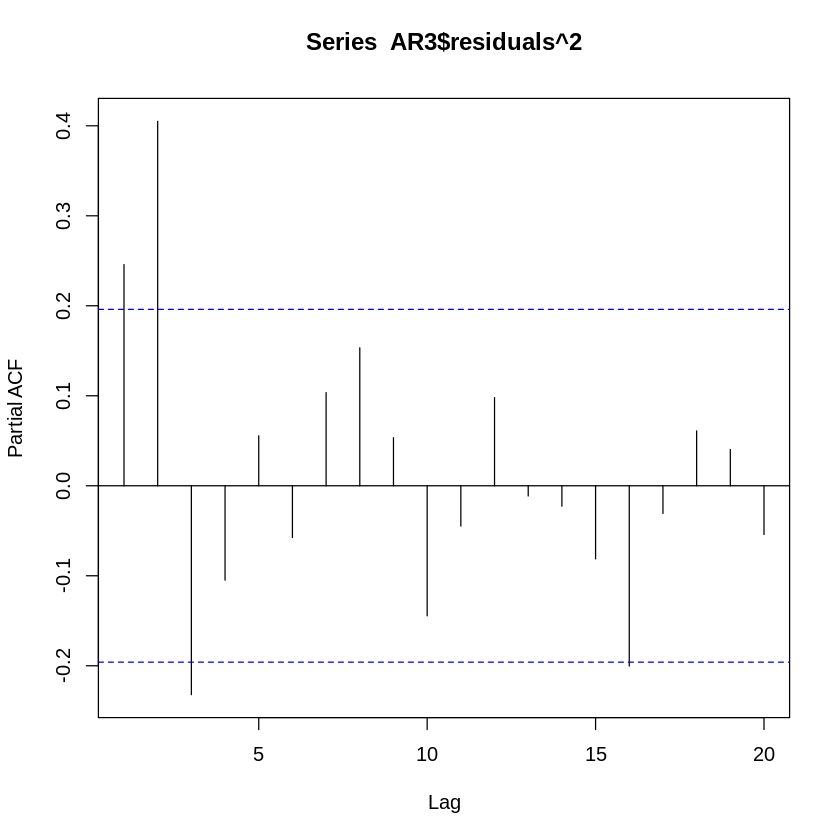

In [38]:
pacf(AR3$residuals^2)

On utilise la fonction ArchTest de la library FinTS (il existe d'autres fonctions dans les packages ATSA et NortsTest notamment)

On teste l'hypothèse d'absence d'effet ARCH avec quatre retards. La régression estimée est :

$$
\hat{\epsilon}_{t}^{2}= \gamma_{0} + \gamma_{1} \hat{\epsilon}_{t-1}^{2} +\gamma_{2} \hat{\epsilon}_{t-2}^{2} +\gamma_{3} \hat{\epsilon}_{t-3}^{2} +\gamma_{4} \hat{\epsilon}_{t-4}^{2} + v_{t}
$$


Les hypothèses du test sont :

$$
\left\{
\begin{array}{ll}
H_{0} : \gamma_{1}=...=\gamma_{4}=0 \Rightarrow \,pas\,d'effet\,ARCH\\
H_{a} : \gamma_{1}\neq 0\, ou \,... \gamma_{4} \neq 0 \Rightarrow effet\,ARCH
\end{array}
\right.
$$

Les résultats du test d'absence d'effet ARCH figurent ci-dessous :

In [39]:
library(FinTS)
ArchTest(AR3$residuals,lags=4,demean = FALSE)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  AR3$residuals
Chi-squared = 25.704, df = 4, p-value = 3.631e-05


* La statistique de test est $ARCH\_LM = 25.704$.
* Sous $H_{0}$, $LB\_stat$ suit une loi $\chi^{2}(2)$. Les seuils critiques sont :
    + $\chi^{2}_{0.90}(4)=4.61$ pour un risque de première espèce de 10%
    + $\chi^{2}_{0.95}(4)=5.99$ pour un risque de première espèce de 5%
    + $\chi^{2}_{0.99}(4)=9.21$ pour un risque de première espèce de 1%
*  ARCH\_LM = 23.13 est supérieure aux seuils critiques : on ne rejette l'hypothèse nulle d'absence d'effet ARCH pour les résidus pour les risques de première espèce habituel (1%, 5% et 10%)
*  La probabilité critique est égale à $0.000$ : on rejette l'hypothèse nulle d'absence d'effet ARCH
* La hausse exceptionnelle du taux de chômage en 2010 explique ce rejet de l'hypothèse d'homoscédasticité.

### Prévision

#### Calcul des prévision et représentation graphique


On calcule les prévisions pour l'année 2019 (soit à l'horizon h=4) ainsi que leur intervalle de confinance à 95 %.

    Point Forecast    Lo 95    Hi 95
101       4.893957 4.455648 5.332265
102       5.038243 4.258545 5.817942
103       5.201385 4.046954 6.355815
104       5.382795 3.865004 6.900586

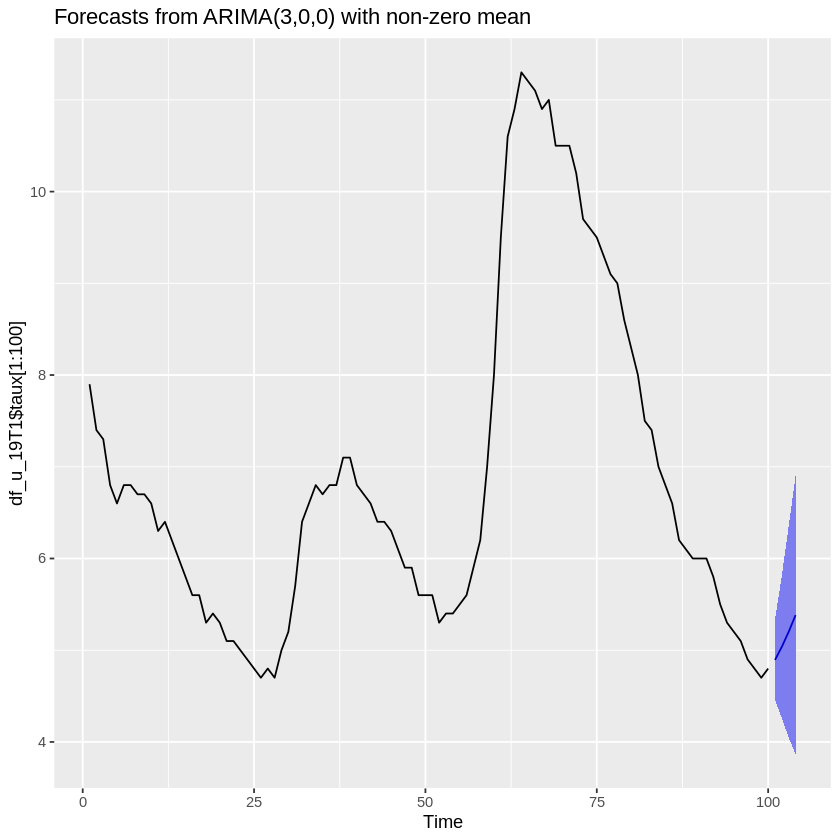

In [40]:
library(forecast)
forecast_AR3<-forecast(AR3,h=4,level=95)
forecast_AR3
autoplot(forecast_AR3)


$$
\left\lbrace
\begin{array}{l}
US\_taux_{t} = 6.9381+\hat{u}_{t}\\
\hat{u}_{t}=1.4712\times \hat{u}_{t-1}-0.2221\times \hat{u}_{t-2}- 0.2827\times \hat{u}_{t-3}+\hat{\epsilon}_{t}
\end{array}
\right.
$$

$$
\begin{aligned}
\Rightarrow US\_taux_{t} - 6.9381 &= 1.4712\times(US\_taux_{t-1} - 6.9381)-0.2221\times (US\_taux_{t-2} - 6.9381)- 0.2827\times(US\_taux_{t-3} - 6.9381)+\hat{\epsilon}_{t}\\
\Rightarrow US\_taux_{t} &  = (1 - 1.4712 + 0.2221 + 0.2827)\times 6.9381+ 1.4712\times US\_taux_{t-1}-0.2221\times US\_taux_{t-2} - 0.2827\times US\_taux_{t-3} +\hat{\epsilon}_{t}\\
\Rightarrow US\_taux_{t} &= 0.2331+ 1.4712\times US\_taux_{t-1}-0.2221\times US\_taux_{t-2} - 0.2827\times US\_taux_{t-3} +\hat{\epsilon}_{t}
\end{aligned}
$$

**Calcul de la prévision pour 2019:T1 (h=1)**

Les prévisions du de  taux de chômage vont dépendre uniquement des trois dernières observations passées

In [ ]:
tail(forecast_AR3$mean,n=4)
tail(df_u_19T1[98:100,])

A Time Series:
[1] 4.893957 5.038243 5.201385 5.382795

date,taux
<date>,<dbl>
2018-04-01,4.8
2018-07-01,4.7
2018-10-01,4.8


$$
\begin{aligned}
US\_taux_{2019:T1}^{a} &= 0.2331+ 1.4712\times US\_taux_{2018:T4}-0.2221\times US\_taux_{2018:T3} - 0.2827\times US\_taux_{2018:T2}\\
\Rightarrow US\_taux_{2019:T1}^{a}&= 0.2331+ 1.4712\times 4.8-0.2221\times 4.7 - 0.2827\times 4.8 = 4.8940
\end{aligned}
$$

**Calcul de la prévision pour 2019:T2 (h=2)**

$$
\begin{aligned}
US\_taux_{2019:T2}^{a}& = 0.2331+ 1.4712\times US\_taux_{2019:T1}^{a}-0.2221\times US\_taux_{2018:T4} - 0.2827\times US\_taux_{2018:T3}\\
\Rightarrow US\_taux_{2019:T1}^{a}&= 0.2331+ 1.4712\times 4.8940-0.2221\times 4.8 - 0.2827\times 4.7 = 5.0384
\end{aligned}
$$

**Calcul de la prévision pour 2019:T3 (h=3)**

$$
\begin{aligned}
US\_taux_{2019:T3}^{a} &= 0.2331+ 1.4712\times US\_taux_{2019:T2}^{a}-0.2221\times US\_taux_{2019:T1}^{a} - 0.2827\times US\_taux_{2018:T4}\\
\Rightarrow US\_taux_{2019:T1}^{a}&= 0.2331+ 1.4712\times 5.0384-0.2221\times 4.8940 - 0.2827\times 4.8 = 5.2016
\end{aligned}
$$

**Calcul de la prévision pour 2019:T4 (h=4)**

$$
\begin{aligned}
US\_taux_{2019:T4}^{a}& = 0.2331+ 1.4712\times US\_taux_{2019:T3}^{a}-0.2221\times US\_taux_{2019:T2}^{a} - 0.2827\times US\_taux_{2019:T1}^{a}\\
\Rightarrow US\_taux_{2019:T1}^{a}&= 0.2331+ 1.4712\times 5.2016-0.2221\times 5.0384 - 0.2827\times 4.8940 = 5.3831
\end{aligned}
$$

Warning message in melt(as.data.frame(df_forc), id.vars = 1):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.data.frame(df_forc)). In the next version, this warning will become an error.”


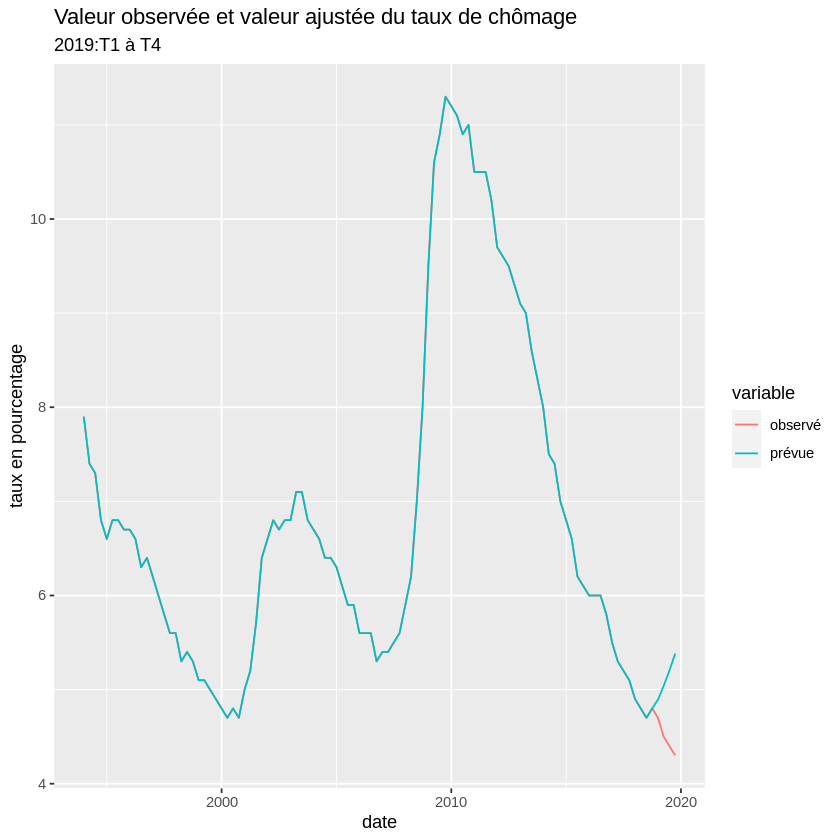

In [42]:
df_forc<-cbind.data.frame(df_u_19T1$date,df_u_19T1$taux,c(df_u_19T1$taux[1:100],as.matrix(forecast_AR3$mean)))

colnames(df_forc)<-c("date","observé","prévue")


data_F_melt=melt(as.data.frame(df_forc),id.vars = 1)

p_g_us<-ggplot(data=data_F_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="taux en pourcentage",title = "Valeur observée et valeur ajustée du taux de chômage",
            subtitle = "2019:T1 à T4")


Le modèle a tendance à surestimer l'évolution future du taux de chômage par rapport à ses valeurs observées.


#### Evaluation des la qualité des prévision hors échantillon

In [ ]:
library(Metrics)
sprintf("MAE out of sample %f",mae(df_forc$observé,df_forc$prévue))
sprintf("RMSE out of sample %f",rmse(df_forc$observé,df_forc$prévue))


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




[1] "MAE out of sample 0.654095"

[1] "RMSE out of sample 0.731776"

La MAE et la RMSE hors échantillon sont plus élevées que leur valeur dans l'ensemble d'estimation (training set). Les valeurs hors échantillon permette d'évaluer plus précisément la qualité prédictive du modèle estimé.





### Ajout de variables indicatrices pour l'année 2008

#### Estimation du modèle AR(3) et tests de spécification


Le [NBER](https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions) date la ``Grande Récession'' de 2007:T4 à 2009:T2. On définit des variables indicatrices individuelles pour les trimestres de la période et on les ajoute au modèle AR(3).

In [ ]:
df_u_19T1$du_07T4<-as.numeric(df_u_19T1$date=="2007-10-01")
df_u_19T1$du_08T1<-as.numeric(df_u_19T1$date=="2008-01-01")
df_u_19T1$du_08T2<-as.numeric(df_u_19T1$date=="2008-04-01")
df_u_19T1$du_08T3<-as.numeric(df_u_19T1$date=="2008-07-01")
df_u_19T1$du_08T4<-as.numeric(df_u_19T1$date=="2008-10-01")
df_u_19T1$du_09T1<-as.numeric(df_u_19T1$date=="2009-01-01")
df_u_19T1$du_09T2<-as.numeric(df_u_19T1$date=="2009-04-01")
AR3_DU<-Arima(y = df_u_19T1$taux[1:100],order=c(3,0,0),xreg=as.matrix(df_u_19T1[1:100,c("du_07T4","du_08T1","du_08T2","du_08T3","du_08T4")]))
summary(AR3_DU)

Series: df_u_19T1$taux[1:100] 
Regression with ARIMA(3,0,0) errors 

Coefficients:
         ar1     ar2      ar3  intercept  du_07T4  du_08T1  du_08T2  du_08T3
      1.3695  0.0147  -0.4161     6.9857  -0.2732  -0.4862  -0.8770  -0.8307
s.e.  0.0965  0.1795   0.0977     0.6010   0.1656   0.2192   0.2518   0.2197
      du_08T4
      -0.7372
s.e.   0.1724

sigma^2 = 0.04399:  log likelihood = 16.32
AIC=-12.63   AICc=-10.16   BIC=13.42

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.004025858 0.2000762 0.1623374 -0.1342594 2.400261 0.7475073
                    ACF1
Training set -0.05642529

In [ ]:
library(lmtest)
coeftest(AR3_DU)


z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1        1.369548   0.096488 14.1940 < 2.2e-16 ***
ar2        0.014652   0.179471  0.0816 0.9349347    
ar3       -0.416099   0.097695 -4.2592 2.052e-05 ***
intercept  6.985707   0.601042 11.6227 < 2.2e-16 ***
du_07T4   -0.273223   0.165582 -1.6501 0.0989278 .  
du_08T1   -0.486212   0.219196 -2.2182 0.0265435 *  
du_08T2   -0.876987   0.251757 -3.4835 0.0004950 ***
du_08T3   -0.830660   0.219713 -3.7807 0.0001564 ***
du_08T4   -0.737217   0.172393 -4.2764 1.900e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Commentaires**

* Le coefficient de l'AR(2) n'est plus significatif. La constante et les coefficients de l'AR(1) et l'AR(3) sont significatifs à 1% et leur ordre de grandeur est proche de celui du modèle sans indicatrices.
* Toutes les indicatrices sont significatives au moins à 10% (du_07T4), à 5% (du_08T1) ou à 1%
* Le critère AIC est plus petit que pour la régression sans indicatrice, le critère BIC est plus élevé.
* La RMSE et la MAE reportée sont les valeurs pour l'échantillon d'estimation ("Training set"). On va comparer les comparer à leur valeur hors échantillon ("out-of-sample") en calculant des prévisions pour des observations n'ayant pas été utilisées pour estimer le modèle.


On représente ci-dessous les valeurs observées et les valeurs prédites par le modèle. On voit que les deux courbes sont assez proches, ce qui permet de penser que la qualité de l'ajustement n'est pas trop mauvaise.



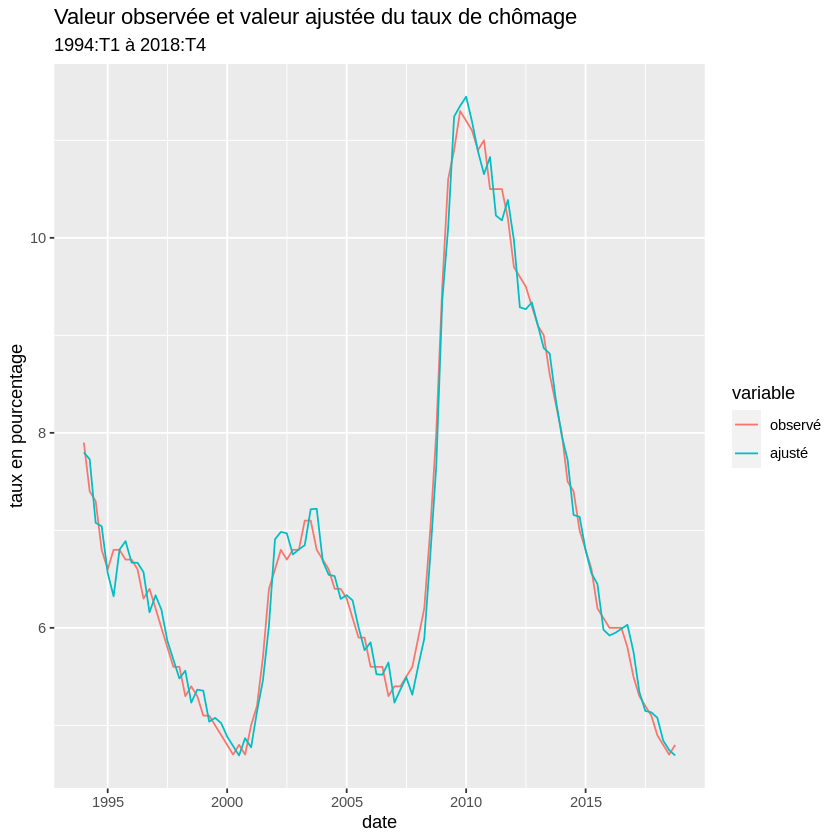

In [ ]:
library(ggplot2)
library(reshape2)

df_plot<-data.frame(df_u_19T1$date[1:100],df_u_19T1$taux[1:100],F=as.matrix(AR3_DU$fitted))
colnames(df_plot)<-c("date","observé","ajusté")

data_melt=melt(as.data.frame(df_plot),id.vars = 1)

p_F_us<-ggplot(data=data_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_F_us+labs(y="taux en pourcentage",title = "Valeur observée et valeur ajustée du taux de chômage",
            subtitle = "1994:T1 à 2018:T4")

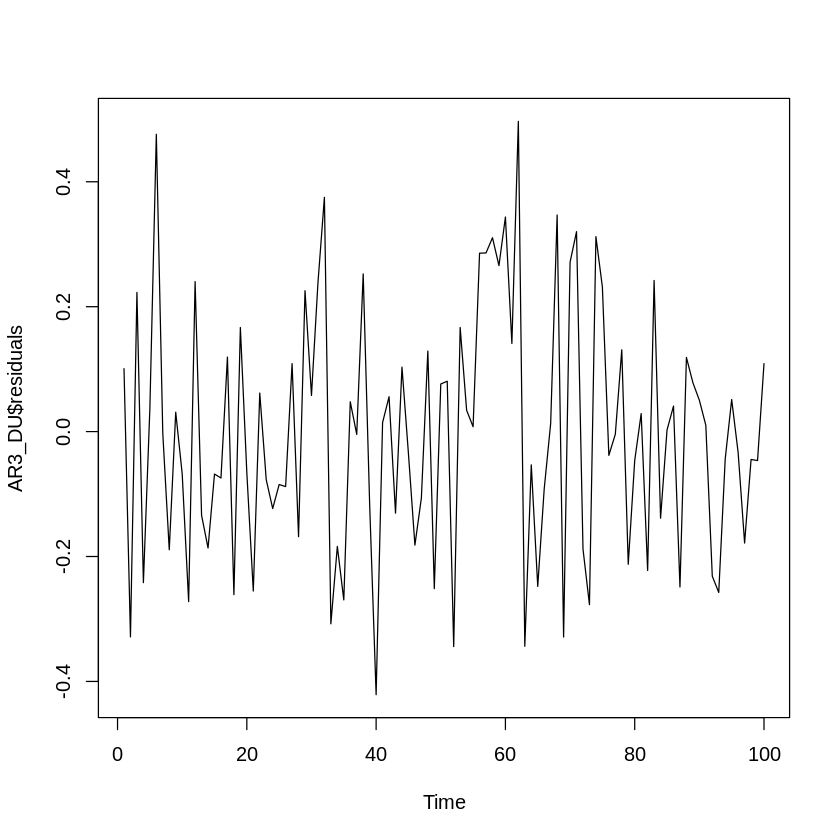

In [ ]:
library(tseries)
library(FinTS)
plot(AR3_DU$residuals)

In [ ]:
jarque.bera.test(AR3_DU$residuals)
ArchTest(AR3_DU$residuals,lags=4,demean = FALSE)


	Jarque Bera Test

data:  AR3_DU$residuals
X-squared = 2.1188, df = 2, p-value = 0.3467



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  AR3_DU$residuals
Chi-squared = 2.538, df = 4, p-value = 0.6378


**Commentaires**
* On ne rejette pas l'hypothèse nulle de loi normale (test de Jarque et Bera) pour un risque de première espèce de 1%.
* On ne rejette pas l'hypothèse nulle d'absence d'effet ARCH (test de Engle-Granger) pour un risque de première espèce de 1%.
* Les variables indicatrices pour la période de la Grande Récession permettent d'obtenir des résidus compatibles avec la loi normale et sans effet ARCH.


#### Prévision

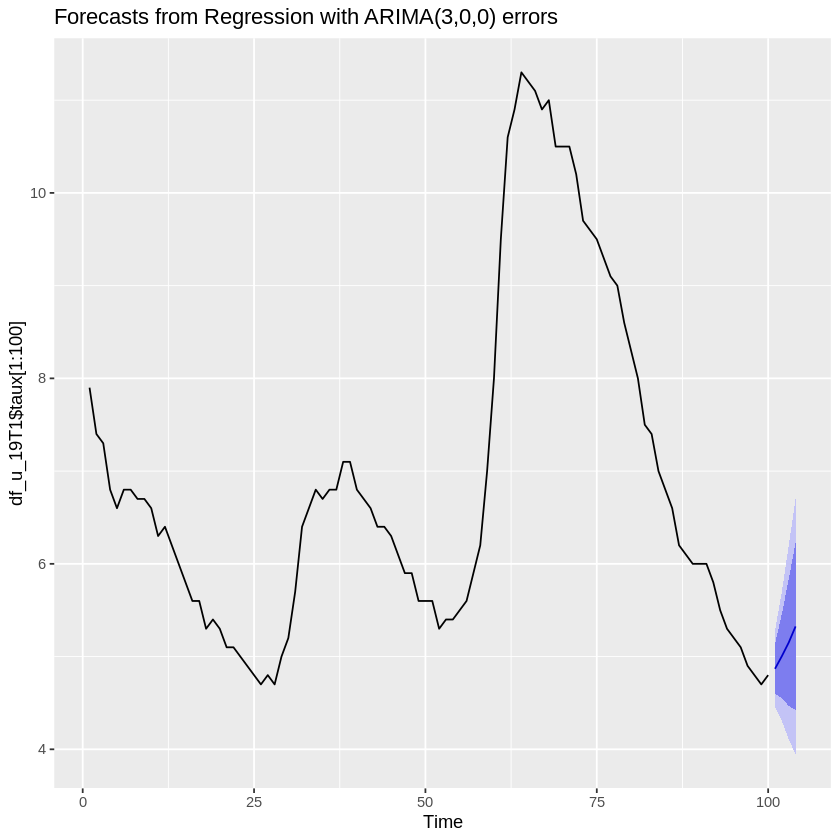

In [ ]:
library(forecast)
forecast_DU<-forecast(AR3_DU,h=4, xreg = as.matrix(df_u_19T1[101:104,c("du_07T4","du_08T1","du_08T2","du_08T3","du_08T4")]))
autoplot(forecast_DU)


Le calcul des prévisions se fait exactement comme avec le modèle sans indicatrices. Dans notre cas, les indicatrices sont définies par rapport à des dates données. Leurs valeurs futures sont égales à 0.


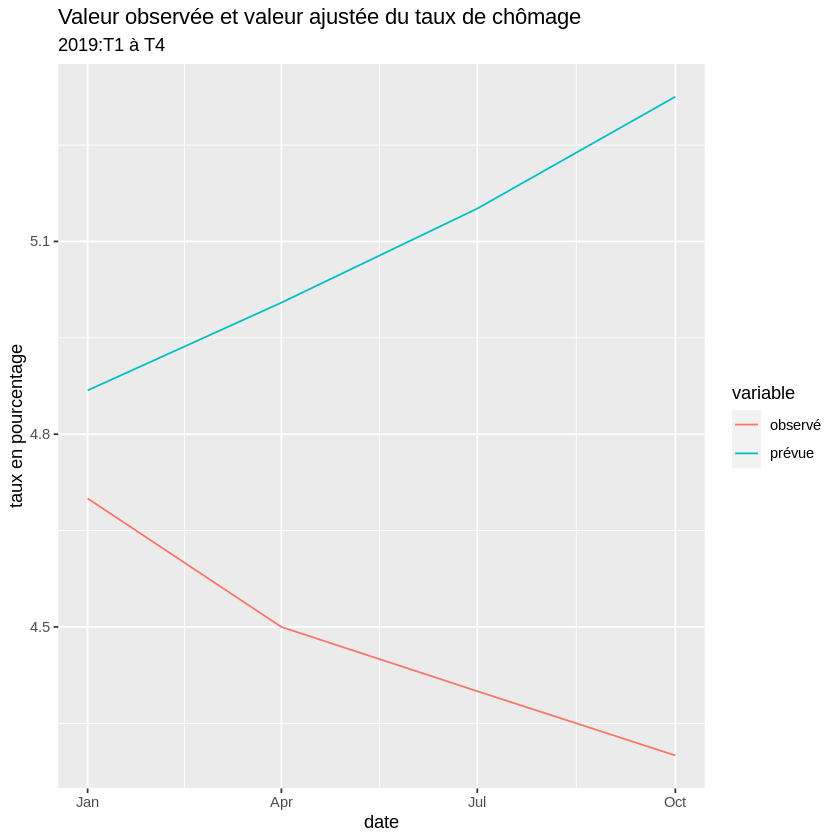

In [ ]:
df_forc_DU<-data.frame(df_u_19T1$date[101:104],df_u_19T1$taux[101:104],as.matrix(forecast_DU$mean))

colnames(df_forc_DU)<-c("date","observé","prévue")


data_F_DU_melt=melt(as.data.frame(df_forc_DU),id.vars = 1)

p_g_us<-ggplot(data=data_F_DU_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="taux en pourcentage",title = "Valeur observée et valeur ajustée du taux de chômage",
            subtitle = "2019:T1 à T4")

Comme avec le modèle précédent, les valeurs prévues sont plus élevées que les valeurs observées.

In [ ]:
library(Metrics)
sprintf("MAE out of sample %f",mae(df_forc_DU$observé,df_forc_DU$prévue))
sprintf("RMSE out of sample %f",rmse(df_forc_DU$observé,df_forc_DU$prévue))


[1] "MAE out of sample 0.612411"

[1] "RMSE out of sample 0.688988"

La RMSE et la MAE sont plus faibles pour les prévisions obtenues du modèle sans indicatrices. Les indicatrices ont donc améliorer les capacités prédictives du modèles même si l'évolution future du taux de chômage est surestimée.

##  Estimation sur la totalité de l'échantillon 1994:T1 à 2023:T1

L'échantillon total est caractérisé notamment par la hausse brutale et temporaite du taux de chômage pendant l'épidémie de covid. Après cette période, le taux de chômage revient à des niveaux comparables à ses valeurs passées. On devra sans doute introduire des variables indicatrices pour prendre en compte les effets de l'épidémie de covid.

### Première estimation

On commence par estimer l'autocorrélogramme.

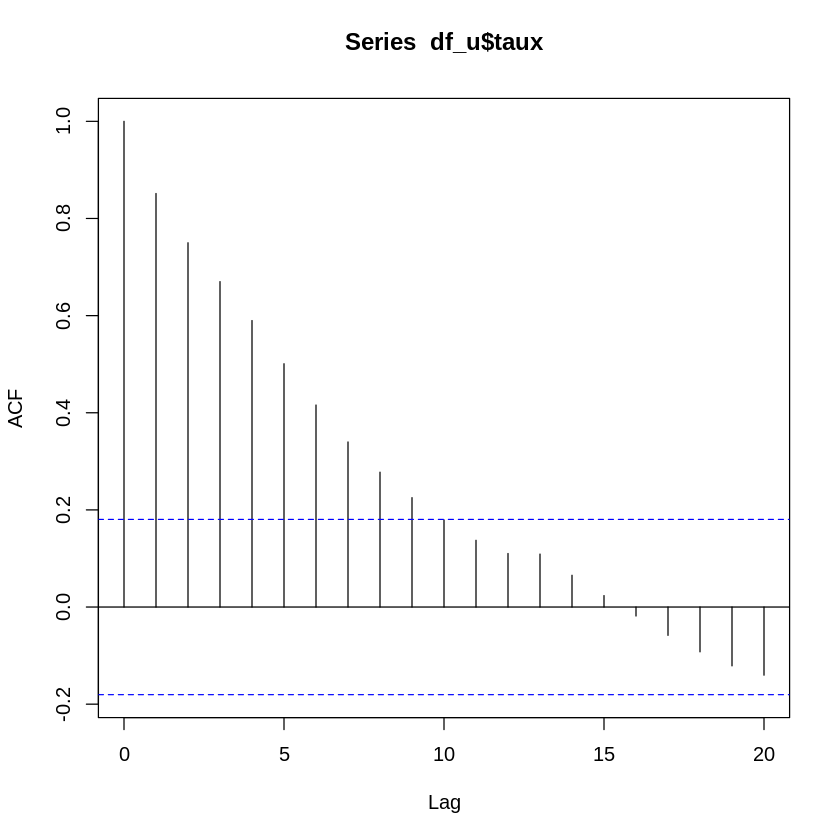

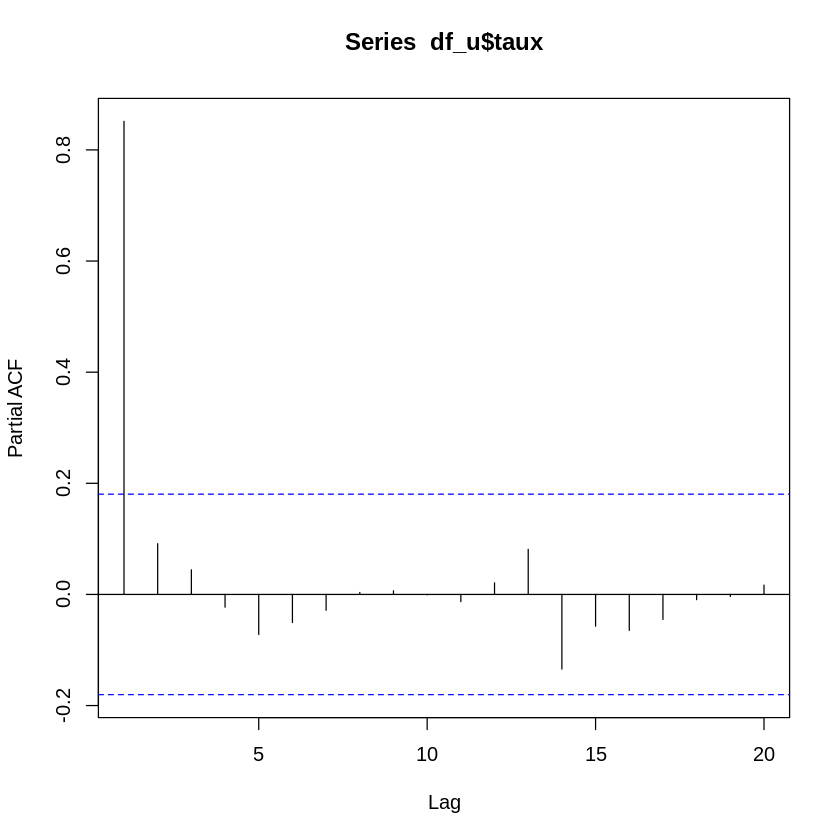

In [ ]:
acf(x = df_u$taux)
pacf(x = df_u$taux)

**Commentaires**

* Pas de modification des autocorrélations par rapport à la période 1994:T1-2019:T4
* Seule l'autocorrélation partielle à l'ordre 1 est maintenant significitive.




On estime dans un premier temps un AR(1)

In [ ]:
AR1_C<-Arima(y = df_u$taux[1:114],order=c(1,0,0))
summary(AR1_C)
coeftest(AR1_C)

Series: df_u$taux[1:114] 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.8492  6.7483
s.e.  0.0483  0.6110

sigma^2 = 1.081:  log likelihood = -165.82
AIC=337.64   AICc=337.86   BIC=345.85

Training set error measures:
                      ME     RMSE       MAE       MPE    MAPE     MASE
Training set -0.01333289 1.030493 0.4379158 -1.822542 5.83886 1.183839
                    ACF1
Training set -0.07833147


z test of coefficients:

          Estimate Std. Error z value  Pr(>|z|)    
ar1       0.849237   0.048324  17.574 < 2.2e-16 ***
intercept 6.748346   0.610995  11.045 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



**Commentaires**
*   La constante et le coefficient ar1 sont significativement différents de 0


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with non-zero mean
Q* = 2.1064, df = 9, p-value = 0.9897

Model df: 1.   Total lags used: 10



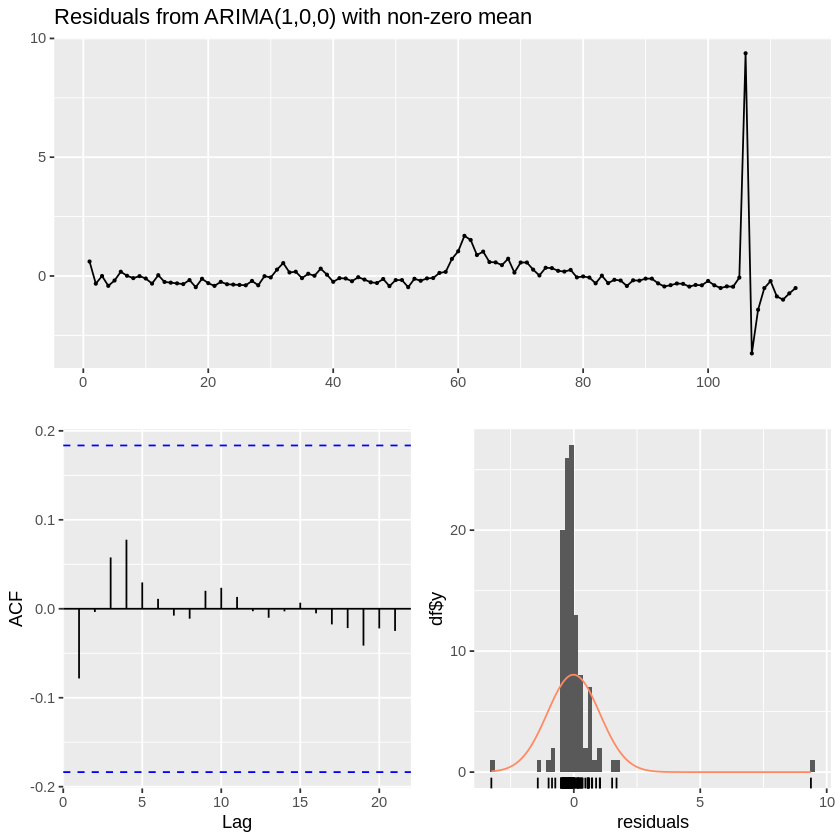

In [ ]:
checkresiduals(AR1_C)

**Commentaires**
*    Le test de Ljung-Box avec 10 retards ne rejette pas l'hypothèse de nullité des 10 premières autocorrélations.

In [ ]:
jarque.bera.test(AR1_C$residuals)
ArchTest(AR1_C$residuals,lags=4,demean = FALSE)


	Jarque Bera Test

data:  AR1_C$residuals
X-squared = 17061, df = 2, p-value < 2.2e-16



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  AR1_C$residuals
Chi-squared = 1.3248, df = 4, p-value = 0.8572


**Commentaires**
* Le test de Jarque et Bera rejette l'hypothèse nulle de normalité des résidus
* Le test ARCH rejette l'hypothèse nulle d'absence d'effet ARCH.



### Ajout de variables indicatrices



On va essayer d'améliorer le modèle en ajoutant des variables indicatrices :

* pour la crise de 2007-2008 comme précédemment
* pour la crise du covid

L'ajout de ces indicatrices va nous obliger à augmenter le nombre de retards et de passer un AR(2). En effet, l'AR(1) avec les indicatrices présente de l'autocorrélation des résidus.

In [ ]:
df_u$du_07T4<-as.numeric(df_u$date=="2007-10-01")
df_u$du_08T1<-as.numeric(df_u$date=="2008-01-01")
df_u$du_08T2<-as.numeric(df_u$date=="2008-04-01")
df_u$du_08T3<-as.numeric(df_u$date=="2008-07-01")
df_u$du_08T4<-as.numeric(df_u$date=="2008-10-01")
df_u$du_09T1<-as.numeric(df_u$date=="2009-01-01")
df_u$du_09T2<-as.numeric(df_u$date=="2009-04-01")


df_u$du_20T1<-as.numeric(df_u$date=="2020-01-01")
df_u$du_20T2<-as.numeric(df_u$date=="2020-04-01")
df_u$du_20T3<-as.numeric(df_u$date=="2020-07-01")
df_u$du_20T4<-as.numeric(df_u$date=="2020-10-01")


AR2_DU_C<-Arima(y = df_u$taux[1:114],order=c(2,0,0),xreg=as.matrix(df_u[1:114,c("du_09T1","du_09T2","du_20T2","du_20T3","du_20T4")]))
summary(AR2_DU_C)

Series: df_u$taux[1:114] 
Regression with ARIMA(2,0,0) errors 

Coefficients:
         ar1      ar2  intercept  du_09T1  du_09T2  du_20T2  du_20T3  du_20T4
      1.7189  -0.7500     6.6784   0.4125   0.4928   8.9798   3.7109   1.0614
s.e.  0.0610   0.0613     0.6486   0.1440   0.1440   0.1661   0.2198   0.1664

sigma^2 = 0.05604:  log likelihood = 4.14
AIC=9.71   AICc=11.44   BIC=34.34

Training set error measures:
                       ME      RMSE      MAE        MPE     MAPE      MASE
Training set -0.005705431 0.2282715 0.185318 -0.2592124 2.796242 0.5009792
                    ACF1
Training set -0.05851422

In [ ]:
coeftest(AR2_DU_C)


z test of coefficients:

           Estimate Std. Error  z value  Pr(>|z|)    
ar1        1.718871   0.061019  28.1696 < 2.2e-16 ***
ar2       -0.749985   0.061325 -12.2297 < 2.2e-16 ***
intercept  6.678420   0.648602  10.2966 < 2.2e-16 ***
du_09T1    0.412526   0.144021   2.8643 0.0041788 ** 
du_09T2    0.492830   0.144041   3.4215 0.0006229 ***
du_20T2    8.979818   0.166142  54.0490 < 2.2e-16 ***
du_20T3    3.710910   0.219788  16.8841 < 2.2e-16 ***
du_20T4    1.061389   0.166369   6.3797 1.774e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Commentaires**

* Les trois indicatrices relatives à l'année 2020T2, T3 et T4 sont significatives et positives pour un risque de première espèce de 1%
* Seules les indicatrices pour 2009:T1 et 2009:T2 s'avèrent significatives quand on prend en compte la totalité des observations pour un risque de première espèce de 1%.
* La constante et les coefficients ar1 et ar2 sont significatifs pour un risque de première espèce de 1%
* Les critères AIC et BIC sont nettement plus petits que pour le AR(1) sant indicatrices.




	Ljung-Box test

data:  Residuals from Regression with ARIMA(2,0,0) errors
Q* = 11.056, df = 8, p-value = 0.1985

Model df: 2.   Total lags used: 10



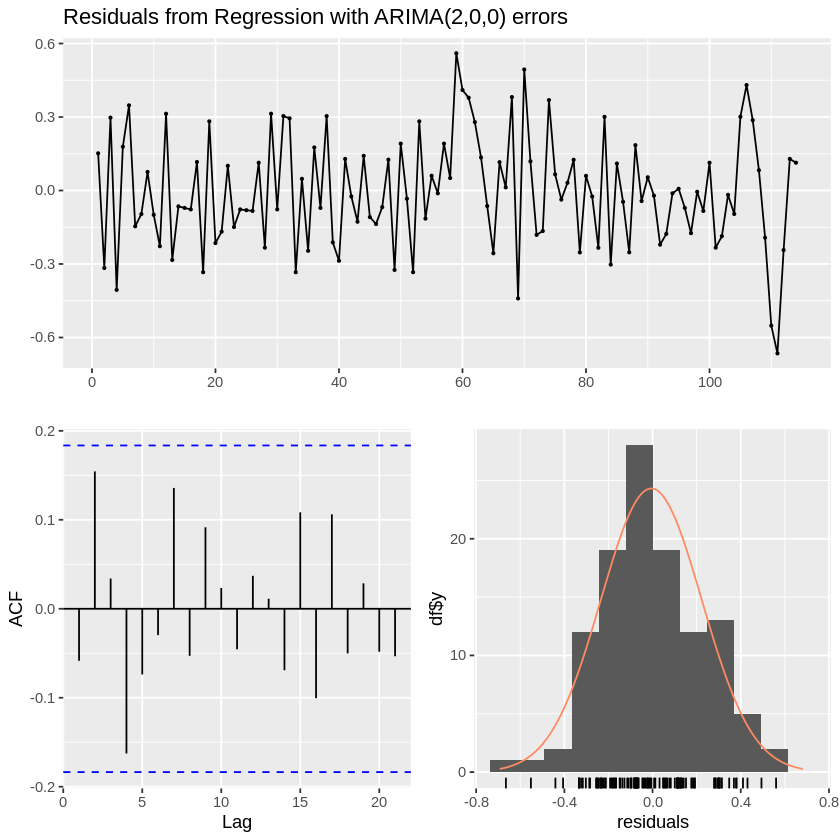

In [ ]:
checkresiduals(AR2_DU_C)

In [ ]:
jarque.bera.test(AR2_DU_C$residuals)
ArchTest(AR2_DU_C$residuals,lags=4,demean = FALSE)


	Jarque Bera Test

data:  AR2_DU_C$residuals
X-squared = 0.13528, df = 2, p-value = 0.9346



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  AR2_DU_C$residuals
Chi-squared = 22.9, df = 4, p-value = 0.0001326


**Commentaires**

*     Le test de Jarque et Bera ne rejette plus l'hypothèse de normalités des résidus
*     Le test ARCH rejette encore l'hypothèse nulle d'absence d'effet ARCH. Malgrè l'introduction de variables indicatrices, la variance du taux de chômage dépend du temps.

### Prévision

On calcule les prévisions à partir du modèle AR(2) avec les indicatrices

Warning message in forecast.forecast_ARIMA(AR3_DU, h = 4, xreg = as.matrix(df_u[114:118, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


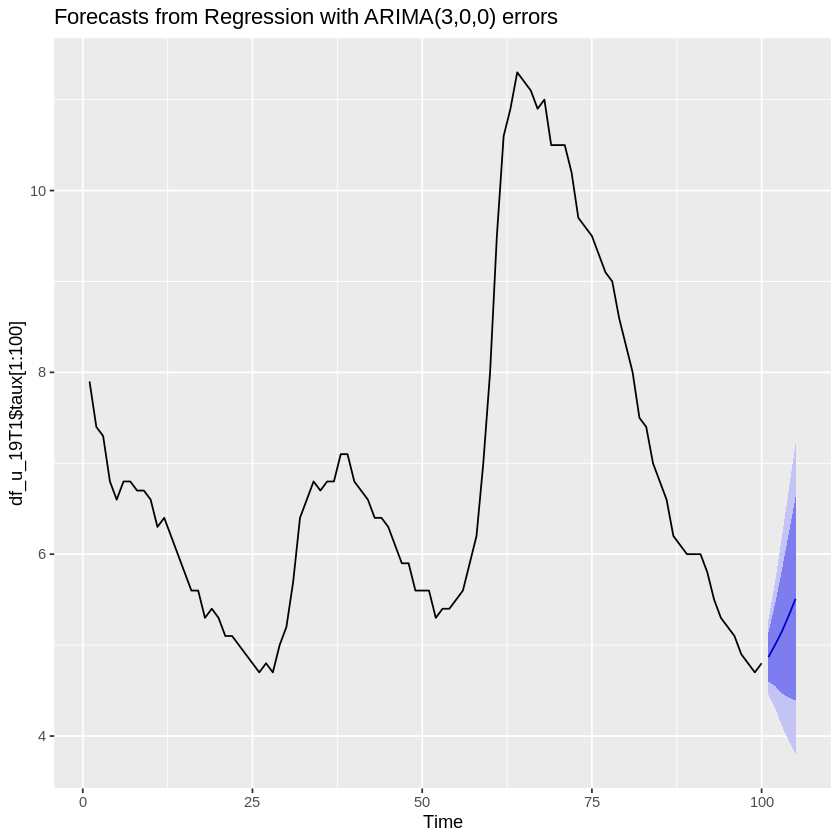

In [ ]:
library(forecast)
forecast_DU_C<-forecast(AR3_DU,h=4, xreg = as.matrix(df_u[114:118,c("du_09T1","du_09T2","du_20T2","du_20T3","du_20T4")]))
autoplot(forecast_DU_C)

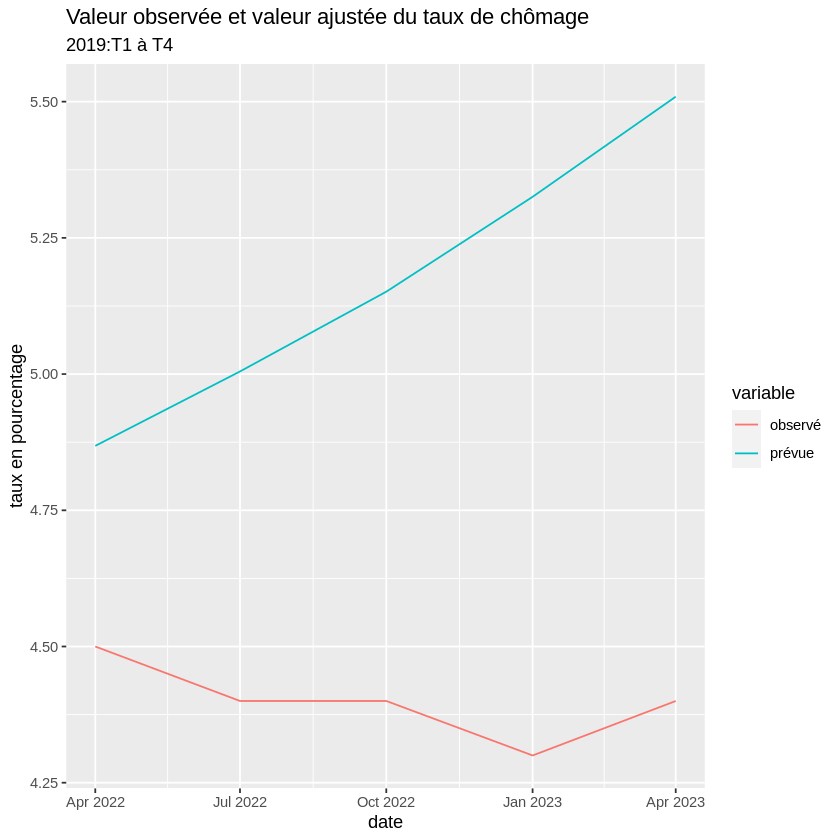

In [ ]:
df_forc_DU<-data.frame(df_u$date[114:118],df_u$taux[114:118],as.matrix(forecast_DU_C$mean))

colnames(df_forc_DU)<-c("date","observé","prévue")


data_F_DU_melt=melt(as.data.frame(df_forc_DU),id.vars = 1)

p_g_us<-ggplot(data=data_F_DU_melt,aes(x=date))+geom_line(aes(x=date,y=value,color= variable))
p_g_us+labs(y="taux en pourcentage",title = "Valeur observée et valeur ajustée du taux de chômage",
            subtitle = "2019:T1 à T4")

Le modèle surestime l'évolution future du taux de chômage.

In [ ]:
library(Metrics)
sprintf("MAE out of sample %f",mae(df_forc_DU$observé,df_forc_DU$prévue))
sprintf("RMSE out of sample %f",rmse(df_forc_DU$observé,df_forc_DU$prévue))

[1] "MAE out of sample 0.771754"

[1] "RMSE out of sample 0.818200"

La MAE et la RMSE du modèle out-of-sample sont plus élevés que leur valeur "in sample" (RMSE et MAE in training)


## Méthodes d'estimations alternatives



On présente quelques fonctions et packages alternatifs.



### auto.arima



Dans la librairie forecast, la fonction auto.arima permet de sélectionner le meilleur modèle en spcifiant le nombre de retards maximum pour la composante AR (max.p), la composante MA (max.q),
le nombre de différenciation de la série (max.d). Ici on a contraint max.d=0 mais sa valeur par défaut est max.d=1

In [ ]:
best_ARMA <-auto.arima(df_u_19T1$taux,max.p = 4,max.q=4,max.d=0)
class(best_ARMA)
summary(best_ARMA)
arimaorder(best_ARMA)

[1] "forecast_ARIMA" "ARIMA"          "Arima"

Series: df_u_19T1$taux 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2      ar3    mean
      1.4785  -0.2325  -0.2760  6.7872
s.e.  0.0949   0.1745   0.0955  0.6715

sigma^2 = 0.049:  log likelihood = 8.73
AIC=-7.46   AICc=-6.85   BIC=5.76

Training set error measures:
                       ME      RMSE      MAE        MPE     MAPE      MASE
Training set -0.005086007 0.2170553 0.166647 -0.2014136 2.468176 0.7802108
                    ACF1
Training set -0.02324285

p d q 
3 0 0

### Librairie tseries

In [ ]:
library(tseries)
order=c(3,0) # order of the ARMA model c(ARlag,MAlag)
AR2_b = arma(x=df_u_19T1$taux,order=c(2,0),include.intercept=TRUE)
summary(AR2_b) # to display the results


Call:
arma(x = df_u_19T1$taux, order = c(2, 0), include.intercept = TRUE)

Model:
ARMA(2,0)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47452 -0.15826 -0.03582  0.12876  0.84298 

Coefficient(s):
           Estimate  Std. Error  t value Pr(>|t|)    
ar1         1.66830     0.07012   23.794   <2e-16 ***
ar2        -0.68907     0.07058   -9.763   <2e-16 ***
intercept   0.13417     0.08524    1.574    0.116    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Fit:
sigma^2 estimated as 0.05106,  Conditional Sum-of-Squares = 5.16,  AIC = -8.23


### Librairie FinTS

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, include.mean = include.mean, 
    transform.pars = transform.pars, fixed = fixed, init = init, method = method, 
    n.cond = n.cond, optim.control = optim.control, kappa = kappa)

Coefficients:
         ar1      ar2      ar3  intercept
      1.4785  -0.2325  -0.2760     6.7872
s.e.  0.0949   0.1745   0.0955     0.6715

sigma^2 estimated as 0.04711:  log likelihood = 8.73,  aic = -7.46

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


	Box-Ljung test (lag = 5)

data:  fit$resid
X-squared = 3.1726, df = 2, p-value = 0.2047


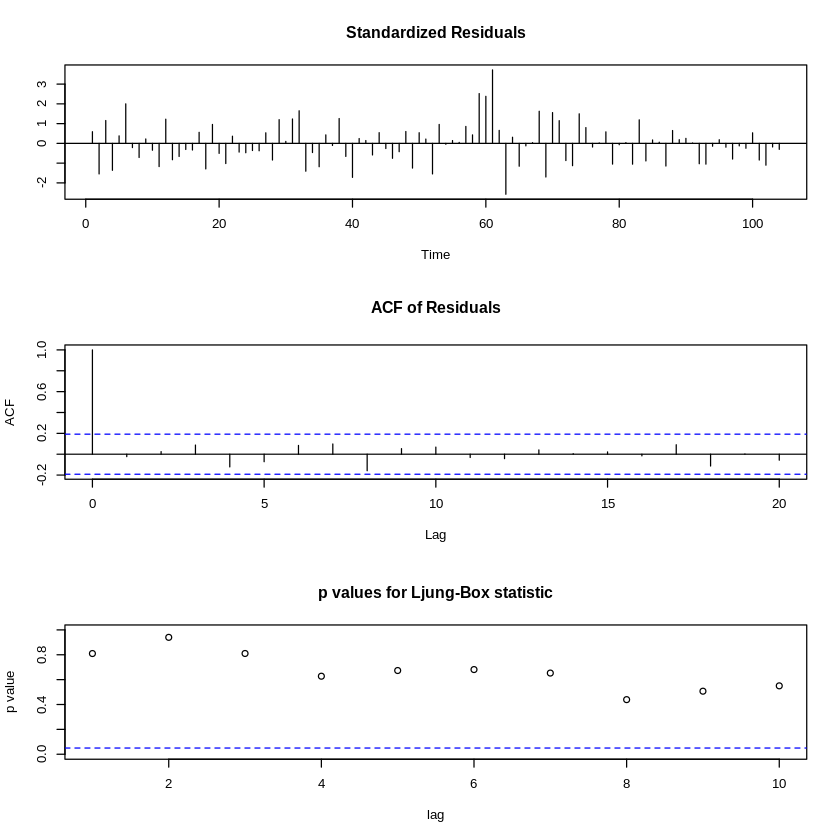

In [ ]:
library(FinTS)
AR2_fin = ARIMA(x = df_u_19T1$taux,order=c(3,0,0),type=c("Ljung-Box"))
summary(AR2_fin)
AR2_fin$Box.test
tsdiag(AR2_fin)

#plotArmaTrueacf(AR2_fin)
#ArchTest(AR2_fin$residuals,lags = 2)